# Imports

In [9]:
import pandas as pd
import numpy as np
from scipy import integrate
import matplotlib.pyplot as plt
import math

# Creating stochastic processes

In [10]:
class StochasticProcess:
    # create stochastic processes for simulating price movements
    def __init__(self,drift,volatility,delta_t,initial_price):
        self.mu = drift # drift direction of movement
        self.sigma = volatility # volatility of an asset
        self.dt = delta_t # time step ex; 1/255 to generate 255 steps of close prices
        self.current_price = initial_price # set the inital price of the asset as the current when creating the class
        self.prices = [initial_price] # have a list of close prices headed by the initial price

    # step through the stochastic process
    def step(self):
        '''
        dS / S = mu * dt + sigma * dW
        dS = (mu * dt + sigma * dW) * S
        Price change = (drift * change_in_time + volatility  * change_in_brownian_motion) * current_asset_price
        '''
        dW = np.random.normal(0, math.sqrt(self.dt)) # generate a change in brownian motion from a normal distribution
        dS = (self.mu * self.dt + self.sigma*dW)*self.current_price # calculate the change in price given GBM parameters and dW
        self.current_price = self.current_price + dS # set the new asset price to the previous price + the price change
        self.prices.append(self.current_price) # append the prices to the price list

class StochasticProcessManager:
    # manages the stochastic process class
    def __init__(self,stochastic_parameters={'drift':None,'volatility':None,'delta_t':None,'initial_price':None}):
        self.stochastic_parameters = stochastic_parameters # set the base parameters of a simulated asset. OPTIONAL
        self.stochastic_keys =['drift', 'volatility', 'delta_t', 'initial_price']
        # if the stochastic process parameters are left to be none then they must be defined in the generate method

    def generate(self,amount=10,stochastic_parameters=None): # generates a set of multiple stochastic prices
        stochastic_parameters = self.stochastic_parameters if stochastic_parameters is None else stochastic_parameters  # override default parameters if not none type
        if type(stochastic_parameters) is not dict:
            raise TypeError(stochastic_parameters,' must be a dictionary') # check if stochastic_parameters is a dictionary type
        elif list(stochastic_parameters.keys()) != self.stochastic_keys: # check to see if the keys correspond to the accepted list of keys
            raise IndexError ('parameter keys do not coincide to', self.stochastic_keys)
        elif not all(stochastic_parameters.values()): # make sure there are no none types in the dictionary values
            raise  TypeError('stochtastic process parameters contain None type')
        elif not all(type(value) is float or int for value in stochastic_parameters.values()): # make sure all the values are numeric
            raise TypeError('stochtastic process parameters contain non numeric type')
        else: # if everything works out then create multiple stochastic simulations
            processes = []
            for i in range(0,amount): # create user defined set of stochastic process
                processes.append(StochasticProcess(drift=stochastic_parameters['drift'],
                                                   volatility=stochastic_parameters['volatility'],
                                                   delta_t=stochastic_parameters['delta_t'],
                                                   initial_price=stochastic_parameters['initial_price']))
            for process in processes:  # for each process
                time_to_expiration = 1  # set time to expiration as 1
                while ((time_to_expiration - process.dt) > 0):  # iterate through the time to expiration using time step dt
                    process.step()  # generate a price movement
                    time_to_expiration -= process.dt  # update the time to expiration

            return processes  # return a list of StochasticProsses objects that contain price lists of simulated price movements

    def absorb_parameters_from_series(self,df,column='Close'): # this method re writes the stochastic parameters with a user defined series
        sample_size = len(df.index) # get the sample size of the price series
        returns = np.log((df[column]/(df[column].shift(-1))))
        std = np.std(returns) # volatility
        annualized_drift = returns.mean * 252 # annualized drift
        annualized_volatility = std * (252**0.5) # annualized volatility

        self.stochastic_parameters={'drift':annualized_drift,
                               'volatility':annualized_volatility,
                               'delta_t':(1/sample_size),
                               'initial_price':df[column].iloc[0]}

    def build_scenarios(self,amount=10,stochastic_parameters=None,column_name='Close',ticker='GBM'): # builds scenarios and then returns them in the same format as the yahooClient.py method
        alphabet_capitalized = 'ABCDEFGHIJKLMNOPQRSTUVWXYZ' # alphabet string capitalized
        random_ticker = ''.join(random.choice(alphabet_capitalized) for letter in range(4))  if ticker is None else ticker# generate a random ticker if one isnt given to the method
        stochastic_tickers = [random_ticker + str(i) for i in range(amount)] # create a list of the tickers with a number ex: [CAT0, CAT1, CAT2 , ... , CATn]
        stochastic_process_list = self.generate(amount=amount, stochastic_parameters=stochastic_parameters) # generate the series
        stochastic_process_df_list = [] # blank list to be filled with the list of nested dictionaries
        for process in stochastic_process_list: # iterate through the list of processes
            stochastic_process_df_list.append(pd.DataFrame(data=process.prices,index=list(np.arange(len(process.prices))),columns= [column_name])) # append casted stochastic data to a df
        scenarios = dict(zip(stochastic_tickers,stochastic_process_df_list)) # build a dictionary of nested pandas dataframes to be used with the backtester
        return scenarios # return the scenario dictionary

# Computing probabilities of asset prices 

In [11]:
def compute_bound(s0, pi, mu, sigma, k):
    return np.log(pi/(s0*np.exp((mu - 0.5*(sigma**2))*k)))/(sigma*np.sqrt(k))

def compute_probability(s0, pi, mu, sigma, k,condition='over'):
    psi = lambda x: ((2*np.pi)**-0.5)*np.exp(-0.5*(x**2))

    if condition == 'over':
      lower_bound = compute_bound(s0, pi, mu, sigma, k)
      result = integrate.quad(psi,lower_bound,np.inf)
    elif condition == 'under':
      upper_bound = compute_bound(s0, pi, mu, sigma, k)
      result = integrate.quad(psi,-np.inf,upper_bound)
    else: return 'error'

    return result[0], result[-1]

# Generate simulated price movements of some asset using some parameters






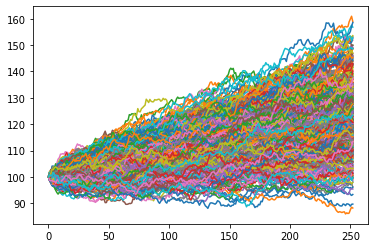

In [12]:
some_asset = {'drift':.2,
              'volatility':.1,
              'delta_t':1/252,
              'initial_price':100} # random parameters

asset_simulator = StochasticProcessManager(stochastic_parameters=some_asset) # create a instance of the SPM

simulations = asset_simulator.build_scenarios(amount=500) # generate 10 different GBM simulations
final_df = pd.DataFrame()
for i in simulations.keys():   # print out all of the price lists
    final_df[i] = simulations[i].Close
    final_df[i].plot()

# Example usage of the probability method

In [13]:
target_price = 110
time_horizon_days = 252
time_horizon = time_horizon_days / 252

probability, error = compute_probability(s0=some_asset['initial_price'],
                                         pi=target_price,mu=some_asset['drift'],
                                         sigma=some_asset['volatility'],
                                         k=time_horizon,
                                         condition='over')

print('There is a ' + str(probability*100) + '% chance that this asset will be above $' + str(target_price) + ' in ' + str(time_horizon_days) + ' days')

There is a 84.05930377321228% chance that this asset will be above $110 in 252 days


# Creating plots and comparing the model to simulated price movements



In [14]:
prices = np.arange(50,200,0.5)
probability_array = np.array([])
for x in prices:
  probability_iter, error = compute_probability(s0=some_asset['initial_price'],
                                         pi=x,
                                         mu=some_asset['drift'],
                                         sigma=some_asset['volatility'],
                                         k=time_horizon)
  probability_array = np.append(probability_array, [probability_iter])

probability_dataframe = pd.DataFrame()
probability_dataframe['price'] = prices
probability_dataframe['theoretical probability'] = probability_array
probability_dataframe.index = probability_dataframe['price']
probability_dataframe = probability_dataframe.drop('price',axis=1)



# actual results
final_slice = final_df.tail(1).T
test_probabilities = np.array([])

for x in prices:
  percentage = (final_slice[final_slice >= x].count() / len(final_slice))
  percentage = percentage.values[0]
  test_probabilities = np.append(test_probabilities,percentage)
  
probability_dataframe['observed probability'] = test_probabilities

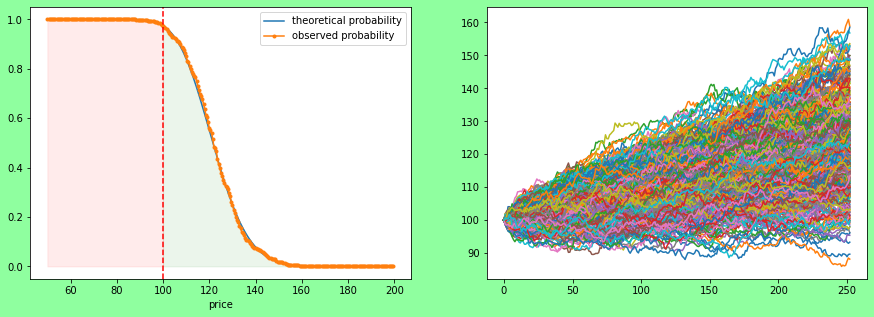

In [15]:
fig, axes = plt.subplots(nrows=1,ncols=2)

ax = probability_dataframe.plot(figsize = (15, 5),style=['-','.-'],ax = axes[0]) 
ax.axvline(x=some_asset['initial_price'],c='r',linestyle="dashed")

final_df.plot(ax = axes[1],legend=False)

loss_df  = probability_dataframe.loc[probability_dataframe.index <= some_asset['initial_price']]
win_df = probability_dataframe.loc[probability_dataframe.index >= some_asset['initial_price']]

ax.fill_between(loss_df.index, loss_df['theoretical probability'], 0,
                 facecolor="red", # The fill color
                 color='red',       # The outline color
                 alpha=0.08)          # Transparency of the fill
ax.fill_between(win_df.index, win_df['theoretical probability'], 0,
                 facecolor="green", # The fill color
                 color='green',       # The outline color
                 alpha=0.08)          # Transparency of the fill


fig.patch.set_facecolor('xkcd:mint green')

## Calculating residuals 

RMSE: 0.007388739902354871


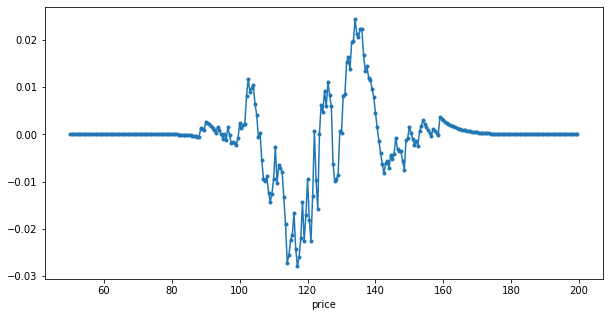

In [16]:
residuals = probability_dataframe['theoretical probability'] - probability_dataframe['observed probability']
rmse = ((residuals**2).mean())**0.5
print('RMSE:', rmse)
residuals.plot(figsize=(10,5),style='.-')


# Analyzing potential outcomes over multiple periods in time

In [17]:
# I will be using the term 'some asset' as a reference of the 
# Lets say we want to take on a bullish position on some asset and we would like to look forward 252 days
# Assume we have gotten the following drift and annualized volatility from some arbitrary source for some asset

trade_limits = (0.10,0.03) # 10% offset_stop , -3% stop loss

some_asset = {'drift':.2,'volatility':.1,
              'delta_t':1/252, # GBM will take 252 steps
              'initial_price':100} # 'Current price of some asset

win_price = some_asset['initial_price']*(1+trade_limits[0]) # set our price which we will define as a win and as a result close our position
loss_price = some_asset['initial_price']*(1-trade_limits[1]) # set our price which we define as a loss AKA we get stopped out


In [18]:
scenario_df = pd.DataFrame() # This dataframe is to store and manage our probabilities in a tabular format
# list to store our probabilities while iterating through the for loop
win_probability_list = []
loss_probability_list = []
breakeven_min_list = []

days = 252

# this method is being used
for x in range(1,days+1):
  current_horizon = x/252
  current_probability_win, error = compute_probability(s0=some_asset['initial_price'], # initial price of some asset
                                      pi=win_price, # the price we define as our win price
                                      mu=some_asset['drift'], # drift of some asset
                                      sigma=some_asset['volatility'], # annualized volatility of some asset
                                      k=current_horizon, # full time horizon
                                      condition='over') # finding the probability that the price will be at or above the win
  
  current_probability_breakeven, error = compute_probability(s0=some_asset['initial_price'], # initial price of some asset
                                      pi=some_asset['initial_price'], # breakeven price
                                      mu=some_asset['drift'], # drift of some asset
                                      sigma=some_asset['volatility'], # annualized volatility of some asset
                                      k=current_horizon, # full time horizon
                                      condition='over') # finding the probability that the price will be at or above the win

  current_probability_loss, error = compute_probability(s0=some_asset['initial_price'], # initial price of some asset
                                      pi=loss_price, # the price we define as our loss price
                                      mu=some_asset['drift'], # drift of some asset
                                      sigma=some_asset['volatility'], # annualized volatility of some asset
                                      k=current_horizon, # full time horizon
                                      condition='under') # finding the probability that the price will be at or below the loss

  win_probability_list.append(current_probability_win)
  loss_probability_list.append(current_probability_loss)
  breakeven_min_list.append(current_probability_breakeven)


scenario_df['general win probability'] = breakeven_min_list
scenario_df['take profit probability'] = win_probability_list
scenario_df['stop loss probability'] = loss_probability_list

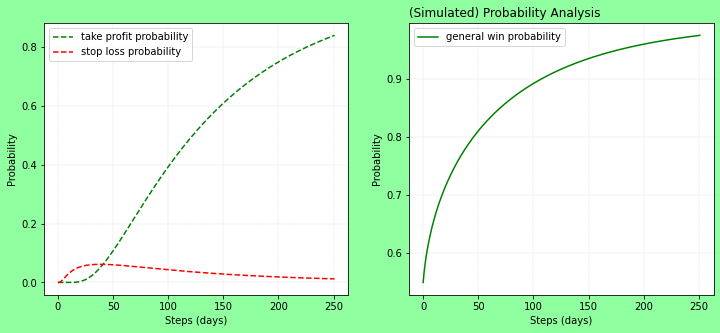

In [19]:
fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(12,5))


ax = scenario_df[['take profit probability','stop loss probability']].plot(style=['g--','r--'], ax=axes[0])
ax2 = scenario_df[['general win probability']].plot(style=['g-'], ax=axes[1])


plt.title('(Simulated) Probability Analysis',loc='left')

ax.grid(linestyle='--', linewidth=0.2)
ax.set_ylabel('Probability')
ax.set_xlabel('Steps (days)')
ax2.grid(linestyle='--', linewidth=0.2)

ax2.set_ylabel('Probability')
ax2.set_xlabel('Steps (days)')
fig.patch.set_facecolor('xkcd:mint green')

Lets plot the win-probability divided by the loss-probability.

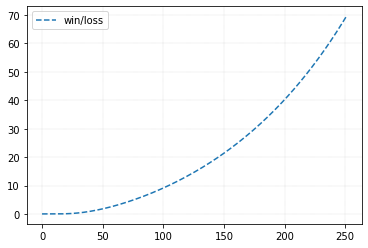

In [ ]:
scenario_df['win/loss'] = scenario_df['take profit probability'] / scenario_df['stop loss probability']
scenario_df[['win/loss']].plot(style='--')
plt.grid(linestyle='--', linewidth=0.2)

# Integrating a kelley criterion for sizing 'bets' not done

In [ ]:
# using a kelley criterion
# (win probability) * (potential gain) > (loss probability)*(potential loss)

# f* = (mean returns - risk free)/sigma^2 - approach 2
# f* = (pb - 1)/(b - 1), where b = potential win + initial wager, bet $10 to win 4 => b = 1.4

# apply this to the general win loss probability

bet_size = scenario_df['general win probability']

In [ ]:
# method to test if trade is reasonable, good to apply to dataframe with win loss probabilities
def check_logic(win_probability,max_profit,max_loss):
  return 1 if win_probability*max_profit > (1-win_probability)*max_loss else 0
  # if true then the trade is 'reasonable' if false then the trade is 'not reasonable'

In [ ]:
scenario_df

,general win probability,take profit probability,stop loss probability,win/loss,logical bet
0,0.548882,3.294325e-51,3.559521e-07,9.254969e-45,1
1,0.568957,3.319363e-26,1.635986e-04,2.028968e-22,1
2,0.584244,7.803250e-18,1.330548e-03,5.864687e-15,1
3,0.597034,1.246022e-13,3.868902e-03,3.220610e-11,1
4,0.608217,4.244322e-11,7.403522e-03,5.732842e-09,1
...,...,...,...,...,...
247,0.973472,8.348984e-01,1.249684e-02,6.680878e+01,1
248,0.973710,8.363414e-01,1.239114e-02,6.749509e+01,1
249,0.973946,8.377714e-01,1.228636e-02,6.818713e+01,1
250,0.974180,8.391886e-01,1.218247e-02,6.888493e+01,1


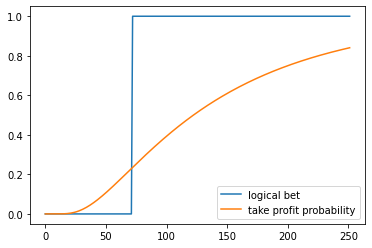

In [ ]:
scenario_df.loc[trade_limits[0]*scenario_df['take profit probability'] > trade_limits[1]*(1 - scenario_df['take profit probability']) ,'logical bet'] = 1
scenario_df.loc[trade_limits[0]*scenario_df['take profit probability'] <= trade_limits[1]*(1 - scenario_df['take profit probability']) ,'logical bet'] = 0
scenario_df[['logical bet','take profit probability']].plot()
# if 1 then the bet is good for the time horizon, if 0 then don't bet

# Creating a class for easier testing

In [ ]:
class StochSignal:
  def __init__(self,parameter_dict=None):
    self.parameters = {'drift':0,'volatility':0} if parameter_dict is None else parameter_dict

  def set_parameters(self,parameter_dict):
    self.parameters = parameter_dict

  def compute_bound(self,s0, pi, mu, sigma, t):
    return np.log(pi/(s0*np.exp((mu - 0.5*(sigma**2))*t)))/(sigma*np.sqrt(t))

  # computes the probability of being above or under a specified price
  def compute_probability(self,s0, pi, mu, sigma, t,condition='over'):
      psi = lambda x: ((2*np.pi)**-0.5)*np.exp(-0.5*(x**2))

      if condition == 'over':
        lower_bound = compute_bound(s0, pi, mu, sigma, t)
        result = integrate.quad(psi,lower_bound,np.inf)
      elif condition == 'under':
        upper_bound = compute_bound(s0, pi, mu, sigma, t)
        result = integrate.quad(psi,-np.inf,upper_bound)
      else: return 'error'
      return result[0], result[-1]
  def build_probability_table(self,s0,sT, conidtion,max_horizon=252):
    if condition == 'over' or condition =='under':
      probability_key = 'probability_'+condition+'_'+str(price)
      probability_dict = {probability_key:[]}
      for x in (1,max_horizon+1):
        probability_dict[probability_key].append(self.compute_probability(s0=s0,
                                                                              pi=sT,
                                                                              mu=self.parameters['drift'],
                                                                              sigma=self.parameters['volatility'],
                                                                              t=x,
                                                                              condition='over'))[0]
        
      probability_df = pd.DataFrame(data=scenario_probabilities,index=np.arange(1,253))
      return probability_df